Подключаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as bs_compare
from bootstrapped import stats_functions as bs_stats
from scipy.stats import kstest
from matplotlib import pyplot as plt
from scipy.stats import shapiro
alpha = 0.05

## Загрузка данных

Получаем данные из файлов: данные по бакетам и по пользователям, и смотрим на них

In [2]:
abt_by_bucket = pd.read_csv('hw_abt_2_bybucket.csv', sep = '\t', index_col=0)
abt_by_user = pd.read_csv('hw_abt_2_byuser.csv', sep = '\t', index_col=0)

In [3]:
abt_by_bucket.head()

,metric_value,users,visits,churn_users,churn_visits
group_id,,,,,
1,1875345.0,155,1419,151,2207
2,1662237.0,138,1320,127,1853
3,1784372.0,128,1281,159,2032
4,1876826.0,163,1644,168,2172
5,1913180.0,156,1675,174,2273


In [4]:
abt_by_user.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
2,10,8261.976,1,10,1,8,B
3,4,5522.000,1,9,1,7,A
4,16,5075.976,1,6,0,8,B


Как и в предыдущем ДЗ, отфильтруем строки, которые кажутся недостоверными: те, в которых сумма целевых действий имеет какое-то значение при нуле целевых сессий и пользователей, совершивших данные действия

In [14]:
abt_by_user = abt_by_user[abt_by_user['visits']!=0]

Выделяем отдельно данные по группе А и по группе B <br>
Затем выделяем данные столбца metric_value для дальнейшего исследования на нормальность и дисперсию <br>
Также сразу смотрим на гистограммы полученных выборок

In [15]:
A_distr = abt_by_user[abt_by_user.group=='A']
B_distr = abt_by_user[abt_by_user.group=='B']

# Анализ метрики metric_value

In [16]:
A_distr_metric = A_distr.metric_value
B_distr_metric = B_distr.metric_value

<AxesSubplot:xlabel='metric_value', ylabel='Count'>

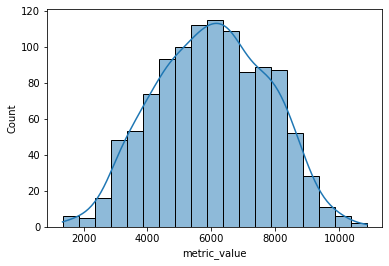

In [17]:
sns.histplot(data=A_distr_metric, kde=True)

<AxesSubplot:xlabel='metric_value', ylabel='Count'>

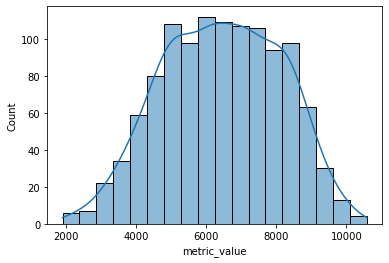

In [18]:
sns.histplot(data=B_distr_metric, kde=True)

## Проверка на нормальность

Из прошлого дз знаем, что сама выборка не нормально распределена, поэтому сгенерируем бутстрапированные подвыборки, и посчитаем на них среднее, получаем уже нормальное распределение. <br>
Нормальность проверяем при помощи критерия Колмогорова, так как в каждой выборке вышло более, чем 5000 значений, и сравниваем наши распределения с сгенерированными нормальными с теми же мат. ожиданиями и дисперсией, чтобы получить правдивый результат.

In [19]:
bs_data_a = bs.bootstrap(np.array(A_distr_metric),
stat_func=bs_stats.mean, num_iterations=10000,
iteration_batch_size=300,
return_distribution=True)

<AxesSubplot:ylabel='Count'>

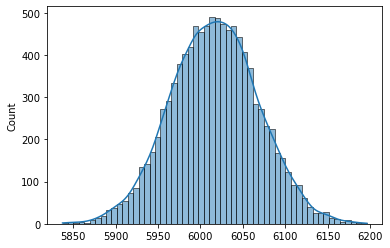

In [20]:
sns.histplot(data=bs_data_a, kde=True)

In [21]:
bs_data_b = bs.bootstrap(np.array(B_distr_metric),
stat_func=bs_stats.mean, num_iterations=10000,
iteration_batch_size=300,
return_distribution=True)

<AxesSubplot:ylabel='Count'>

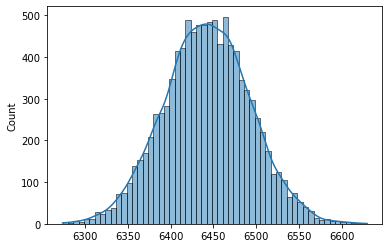

In [22]:
sns.histplot(data=bs_data_b, kde=True)

In [23]:
series = (np.random.normal(loc=bs_data_a.mean(),scale=bs_data_a.std(),size=1000)).astype(int)
st = kstest(bs_data_a, pd.Series(series))
print('Distributions is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distributions is normal



In [24]:
series = (np.random.normal(loc=bs_data_b.mean(),scale=bs_data_b.std(),size=1000)).astype(int)
st = kstest(bs_data_b, pd.Series(series))
print('Distributions is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distributions is normal



Видим, что в таком случае распределения действительно нормальные, а также что дипазон средних в группе B лежит правее, чем в группе A, можем предположить, что есть какие то изменения. Проверим стат. значимость этих изменений 

## Проверка равенства дисперсий

Сравниваем дисперсии данных распределений на этот раз при помощи бутстрапа. Оцениваем их различие при помощи перцентилей, полученных методом bootstrap_ab. Также смотрим на эту разницу двумя способами: с помощью percent_change и ratio. <br>

In [27]:
bs_ab_stds_proc = bs.bootstrap_ab(np.array(A_distr_metric), np.array(B_distr_metric),
bs_stats.std,
bs_compare.percent_change, num_iterations=5000, alpha=0.05,
iteration_batch_size=100, scale_test_by=1)

In [28]:
bs_ab_stds_proc

2.597922847386527    (-2.551394619957547, 7.585826537473316)

In [29]:
bs_ab_stds_rat = bs.bootstrap_ab(np.array(A_distr_metric), np.array(B_distr_metric),
bs_stats.std,
bs_compare.ratio, num_iterations=5000, alpha=0.05,
iteration_batch_size=100, scale_test_by=1)

In [30]:
bs_ab_stds_rat

1.0259792284738654    (0.9771587282618499, 1.074564915307743)

Видим, что интервал percent_change немного смещен влево, но содержит в себе 0. А ratio имеет более узкий диапазон и сосредоточен возле 1. Это может говорить о том, что дисперсии если и различаются, то не значимо. <br>
Это еще раз подтверждает то, что получили в предыдущем домашнем задании: дисперсии равны

Визуализируем полученные результаты для лучшего понимания

In [31]:
bs_ab_stds_proc = bs.bootstrap_ab(np.array(A_distr_metric), np.array(B_distr_metric),
bs_stats.std,
bs_compare.percent_change, num_iterations=5000, alpha=0.05,
iteration_batch_size=100, scale_test_by=1, return_distribution=True)

<AxesSubplot:ylabel='Count'>

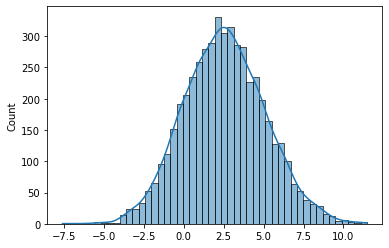

In [32]:
sns.histplot(data=bs_ab_stds_proc, kde=True)

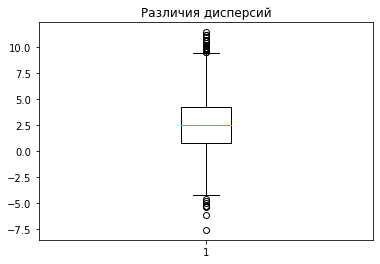

In [34]:
plt.boxplot(bs_ab_stds_proc)
plt.title('Различия дисперсий')
plt.show()

## Проверка стат. значимости

In [35]:
bs_ab_means = bs.bootstrap_ab(np.array(B_distr_metric), np.array(A_distr_metric), 
bs_stats.mean,
bs_compare.percent_change, num_iterations=5000, alpha=0.05,
iteration_batch_size=100, scale_test_by=1)

In [36]:
bs_ab_means

7.085852821612181    (4.616750195589772, 9.38294152752714)

Видим, что данный диапазон не содержит в себе 0, также видим, что нижняя граница указывает значение, близкое к 5 процентам, то есть полученное изменение можно считать значимым, что подтверждает полученные в прошлом дз результаты <br> 
Также сразу видим, какой именно класс имеет большие значения, в данном случае, класс В

In [38]:
bs_ab_means = bs.bootstrap_ab(np.array(B_distr_metric), np.array(A_distr_metric), 
bs_stats.mean,
bs_compare.difference, num_iterations=5000, alpha=0.05,
iteration_batch_size=100, scale_test_by=1)

In [39]:
bs_ab_means

426.31475457875604    (278.2806590619548, 568.0819179805719)

Также можем оценить численно различия в группах, в среднем видим  ≈ 400 прирост целевых действий

Изобразим это на гистограмме и диаграмме размаха для лучшей визуализации

In [40]:
bs_ab_means = bs.bootstrap_ab(np.array(B_distr_metric), np.array(A_distr_metric), 
bs_stats.mean,
bs_compare.percent_change, num_iterations=5000, alpha=0.05,
iteration_batch_size=100, scale_test_by=1, return_distribution=True)

<AxesSubplot:ylabel='Count'>

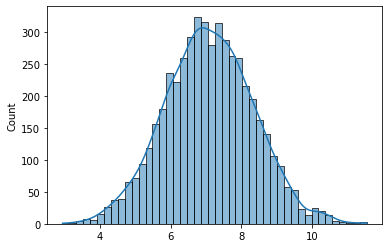

In [41]:
sns.histplot(data=bs_ab_means, kde=True)

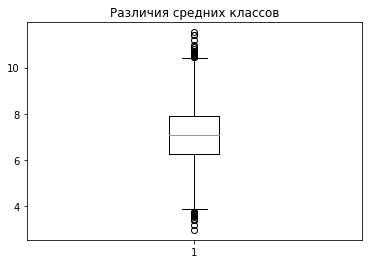

In [42]:
plt.boxplot(bs_ab_means)
plt.title('Различия средних классов')
plt.show()

# Анализ метрики churn_users

In [6]:
A_distr_churn_us = abt_by_bucket.iloc[0:8].churn_users
B_distr_churn_us = abt_by_bucket.iloc[8:].churn_users

<AxesSubplot:xlabel='churn_users', ylabel='Count'>

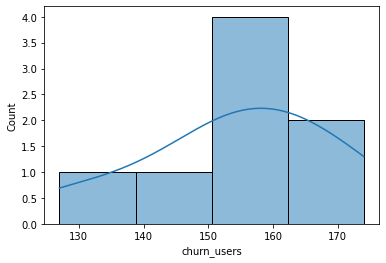

In [7]:
sns.histplot(data=A_distr_churn_us, kde=True)

<AxesSubplot:xlabel='churn_users', ylabel='Count'>

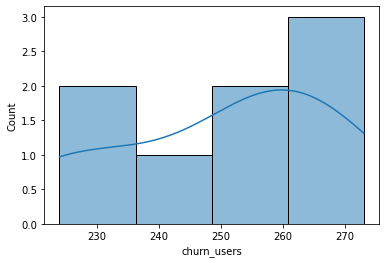

In [8]:
sns.histplot(data=B_distr_churn_us, kde=True)

## Проверка на нормальность

Для всего 8 значений в каждой выборке нет смысла делать бутстрапированные подвыборки, к тому же наши изначальные выборки получились нормальными, поэтому просто еще раз проверим их на нормальность

In [11]:
sh_a = shapiro(A_distr_churn_us)

print('Распределение A {}нормальное\n'.format( {True:'не ',False:''}[sh_a[1] < alpha]))

Распределение A нормальное



In [10]:
sh_b = shapiro(B_distr_churn_us)

print('Распределение A {}нормальное\n'.format( {True:'не ',False:''}[sh_b[1] < alpha]))

Распределение A нормальное



Видим, что снова получили нормально распределенные выборки

## Проверка равенства дисперсий

Теперь проверим, действительно ли дисперсии равны, как это уже было получено

In [46]:
bs_ab_stds_churn = bs.bootstrap_ab(np.array(B_distr_churn_us), np.array(A_distr_churn_us),
bs_stats.std,
bs_compare.percent_change, num_iterations=16, alpha=0.05,
iteration_batch_size=6, scale_test_by=1)

In [47]:
bs_ab_stds_churn

20.063374707348935    (-116.02119447195854, 80.46017369761428)

In [48]:
bs_ab_stds_churn = bs.bootstrap_ab(np.array(B_distr_churn_us), np.array(A_distr_churn_us),
bs_stats.std,
bs_compare.percent_change, num_iterations=5000, alpha=0.05,
iteration_batch_size=100, scale_test_by=1, return_distribution=True)

<AxesSubplot:ylabel='Count'>

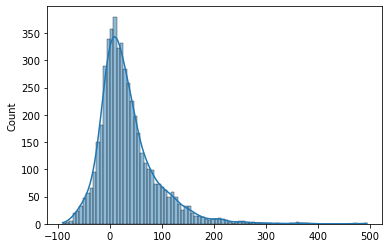

In [49]:
sns.histplot(data=bs_ab_stds_churn, kde=True)

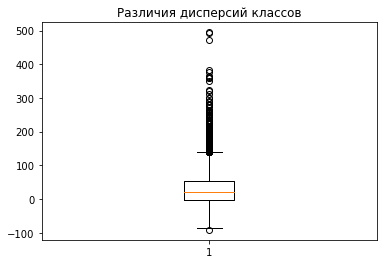

In [50]:
plt.boxplot(bs_ab_stds_churn)
plt.title('Различия дисперсий классов')
plt.show()

Видим, что несмотря на отклонение в среднем от 0, разность дисперсий содержит в своем интервале 0, поэтому можем подтвердить то, что было посчитано в предыдущем дз, дисперсии действительно равны

## Проверка стат. значимости

Проверим, действительно ли различия в наших выборках статистически значимы

In [51]:
bs_ab_means_churn = bs.bootstrap_ab(np.array(B_distr_churn_us), np.array(A_distr_churn_us), 
bs_stats.mean,
bs_compare.percent_change, num_iterations=100, alpha=0.05,
iteration_batch_size=10, scale_test_by=1)

In [52]:
bs_ab_means_churn

62.39870340356564    (51.17561835376789, 74.67827879097871)

In [53]:
bs_ab_means_churn = bs.bootstrap_ab(np.array(B_distr_churn_us), np.array(A_distr_churn_us), 
bs_stats.mean,
bs_compare.percent_change, num_iterations=5000, alpha=0.05,
iteration_batch_size=100, scale_test_by=1, return_distribution=True)

<AxesSubplot:ylabel='Count'>

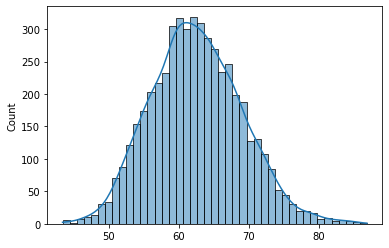

In [54]:
sns.histplot(data=bs_ab_means_churn, kde=True)

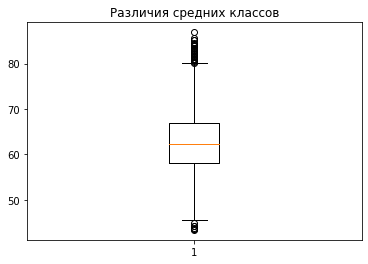

In [55]:
plt.boxplot(bs_ab_means_churn)
plt.title('Различия средних классов')
plt.show()

Видим, что средние отличаются на ≈ 60%, а также наш интервал разностей не содержит 0, тогда можем предположить, что различия действительно существенны

# Выводы

Проверяя полученные на предыдущем этапе выводы с помощью бутстрапа, получили те же самые результаты, 
а именно статистическую значимость различий классов в значениях metric_value и churn_users. <br>
Это подтверждает верность различных критериев, использованных в предыдущем дз.

При исследовании двух метрик выяснилось, что нововведение повлекло значимое увеличение числа целевых действий, 
однако также и значительный прирост пользователей, отказавшихся сделать заказ.

На этом этапе стоит проанализировать, что в перспективе принесет больший доход: нововведение, увеличивающее охваты, либо же старый проверенный метод, который устраивает большее количество пользователей.
Важно посмотреть, что это за пользователи: заказывали ли они ранее, или попали на какую-то популярную рекламу и заказывают впервые